# Momento de Retroalimentación: Módulo 1 Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)

## Isai Ambrocio - A01625101


Instruciones:

Entregable: Uso, procesamiento y visualización de grandes volúmenes de datos..

1. Configura correctamente tu entorno de trabajo en Colab para utilizar PySpark (Preparación del ambiente de trabajo para Big Data en Colab)
1. Una vez configurado tu ambiente de trabajo selecciona una base de datos que se caracterice por tener un gran volumen de datos.
1. Utilizando MLlib genera un modelo inteligente de clasificación, regresión o agrupamiento con la base de datos que seleccionaste (Generación de modelos inteligentes utilizando PySpark y MLLib)
1. Evalua el modelo generado con las herramientas de PySpark.
1. Tomando la información de la base de datos que utilizaste  para entrenar tu modelo inteligente genera un tablero de visualización con una herramienta administrada.
1. Documenta y explica cuál fue el proceso completo que llevaste acabo.
1. Prueba tu modelo con un conjunto de datos y realiza algunas predicciones.
1. Después de la entrega intermedia se te darán correcciones que puedes incluir en tu entrega final.

> Instalación y librerias

In [ ]:
!pip install pyspark py4j

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

> Creamos la sesión de spark

In [17]:
spark = SparkSession.builder.appName("tec2023").getOrCreate()

> ### Regresión Lineal

In [18]:
entrenamiento = spark.read.format("libsvm")\
    .load("/content/sample_linear_regression_data.txt")

In [23]:
regresion_spark = LinearRegression(maxIter = 10,
                                   regParam = 0.3,
                                   elasticNetParam = 0.8)

spark_model = regresion_spark.fit(entrenamiento)

print("Coeficientfes: %s" % str(spark_model.coefficients))
print("Intercepto: %s" % str(spark_model.intercept))

Coeficientfes: [0.0,0.3229251667740594,-0.3438548034562219,1.915601702345841,0.05288058680386255,0.765962720459771,0.0,-0.15105392669186676,-0.21587930360904645,0.2202536918881343]
Intercepto: 0.15989368442397356


In [25]:
resumen_entrenamiento = spark_model.summary

print(f"Numero de iteraciones: {resumen_entrenamiento.totalIterations}")
print(f"Objective History: {resumen_entrenamiento.objectiveHistory}")

Numero de iteraciones: 6
Objective History: [0.49999999999999994, 0.4967620357443381, 0.49363616643404634, 0.4936351537897608, 0.4936351214177871, 0.49363512062528014, 0.4936351206216114]


In [26]:
resumen_entrenamiento.residuals.show()

print("RMSE: %f" % resumen_entrenamiento.rootMeanSquaredError)
print("R2: %f" % resumen_entrenamiento.r2)

+--------------------+
|           residuals|
+--------------------+
|  -9.889232683103197|
|  0.5533794340053553|
|  -5.204019455758822|
| -20.566686715507508|
|    -9.4497405180564|
|  -6.909112502719487|
|  -10.00431602969873|
|  2.0623978070504845|
|  3.1117508432954772|
|  -15.89360822941938|
|  -5.036284254673026|
|  6.4832158769943335|
|  12.429497299109002|
|  -20.32003219007654|
|    -2.0049838218725|
| -17.867901734183793|
|   7.646455887420495|
| -2.2653482182417406|
|-0.10308920436195645|
|  -1.380034070385301|
+--------------------+
only showing top 20 rows

RMSE: 10.189077
R2: 0.022861


> Como podemos observar, los datos de entrenamiento en nuestro modelo tienen un pésimo comportamiento, ya que el valor de $R^2$ es de: 0.022861
Asimismo, `RMSE` presenta un valor alto(10.189077).

> Dada esta situación, es necesario explorar otros enfoques o mejorar la calidad de los datos para lograr predicciones más precisas, ya que el modelo lineal actual no es adecuado para este propósito.

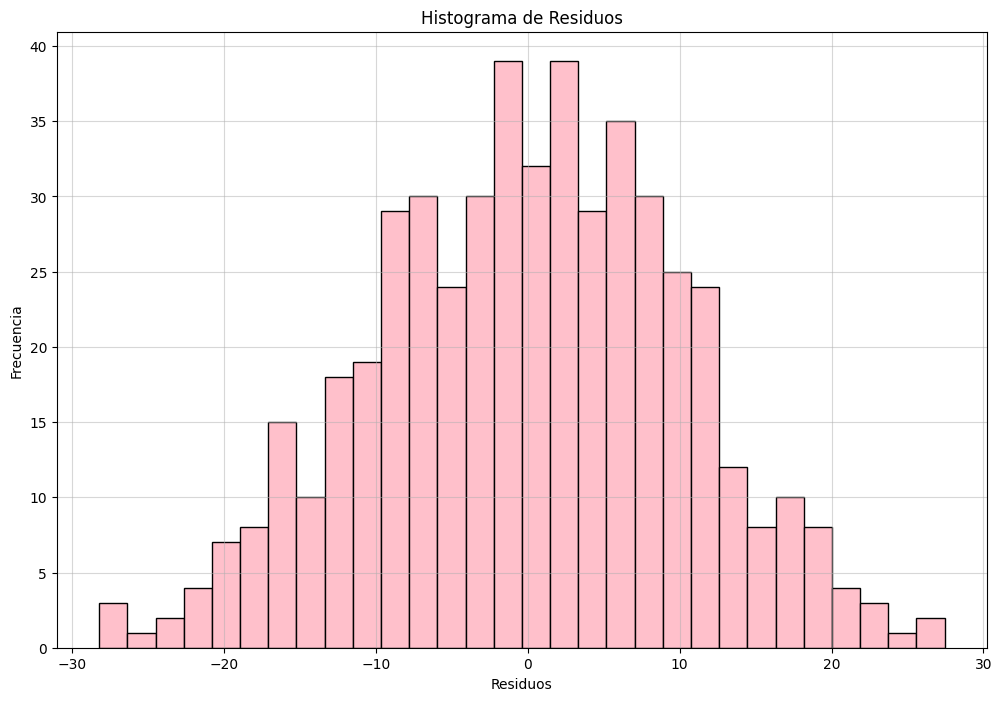

In [36]:
residuos = resumen_entrenamiento.residuals.select("residuals")\
                .rdd.map(lambda row: row.residuals).collect()

plt.figure(figsize = (12, 8))
plt.hist(residuos, bins = 30, color = "pink", edgecolor = "black")
plt.title("Histograma de Residuos")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.grid(alpha = 0.5)
plt.show()

Aquí podemos apreciar por medio del histograma que los valores siguen una distribución normal, lo cual es un buen indicador en esta etapa inicial.


> ### Clasificador

In [38]:
datos = spark.read.format("libsvm").load("/content/sample_libsvm_data.txt")

In [41]:
etiqueta_index = StringIndexer(inputCol = "label",
                               outputCol = "indexedLabel").fit(datos)


caracteristicas_index = VectorIndexer(inputCol = "features",
                                      outputCol = "indexedFeatures",
                                      maxCategories = 4 ).fit(datos)

In [42]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = datos.randomSplit([0.7, 0.3])

rnd_forest = RandomForestClassifier(labelCol = "indexedLabel",
                                    featuresCol = "indexedFeatures",
                                    numTrees = 10)

convertidor_etiquetas = IndexToString(inputCol = "prediction",
                                      outputCol = "predictedLabel",
                                      labels = etiqueta_index.labels)

In [43]:
pipeline = Pipeline(stages=[etiqueta_index,
                            caracteristicas_index, rnd_forest,
                            convertidor_etiquetas])

> Modelado y predicciones

In [46]:
model2 = pipeline.fit(trainingData)
predictions = model2.transform(testData)
predictions.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(692,[122,123,124...|
|           0.0|  0.0|(692,[124,125,126...|
|           0.0|  0.0|(692,[126,127,128...|
|           0.0|  0.0|(692,[126,127,128...|
|           0.0|  0.0|(692,[126,127,128...|
+--------------+-----+--------------------+
only showing top 5 rows



In [50]:
evaluator = MulticlassClassificationEvaluator(labelCol = "indexedLabel",
                                              predictionCol = "prediction",
                                              metricName = "accuracy")

accuracy = evaluator.evaluate(predictions)

print(f"Test Error: {1.0 - accuracy}")

rf_model = model2.stages[2]
print(rf_model)

Test Error: 0.0
RandomForestClassificationModel: uid=RandomForestClassifier_66f50779a14b, numTrees=10, numClasses=2, numFeatures=692


> Utilizamos un modelo de clasificación y evaluamos su rendimiento con el conjunto de prueba. Sin embargo, el error que nos da es de 0, lo cual es preocupante, ya que lo más probale es que el modelo esté sobre ajustadom lo que quiere decir que hizo una memorización,


> ### Matriz de confusión

In [70]:
y = predictions.select("label").rdd.map(lambda row: row.label).collect()
y_hat = predictions.select("prediction")\
        .rdd.map(lambda row: row.prediction).collect()

conf_matrix = confusion_matrix(y, y_hat)

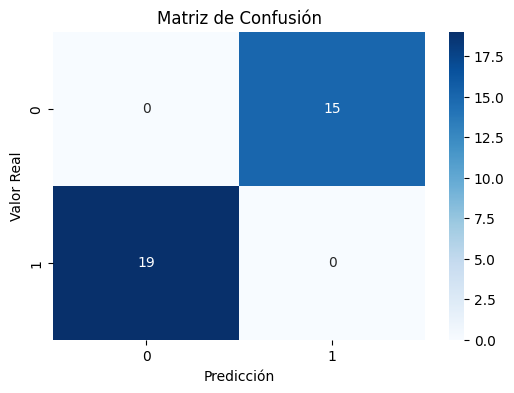

In [72]:
plt.figure(figsize=(6, 4))

sns.heatmap(conf_matrix, cmap = "Blues", annot = True)

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

> ### K-means

In [73]:
data2 = spark.read.format("libsvm").load("/content/sample_kmeans_data.txt")

In [76]:
k_means = KMeans().setK(2).setSeed(1)
model3 = k_means.fit(data2)
prediccion = model3.transform(data2)

In [79]:
evaluador = ClusteringEvaluator()

silueta = evaluador.evaluate(predictions)
print(f"Silueta con distancia euclidiana al cuadrado {silueta}")

centers = model3.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Silueta con distancia euclidiana al cuadrado 0.9997530305375207
Cluster Centers: 
[9.1 9.1 9.1]
[0.1 0.1 0.1]


> El análisis del modelo de K-Means revela resultados altamente prometedores en cuanto a la calidad de la agrupación. La puntuación de silueta, calculada con distancia euclidiana al cuadrado, se sitúa en aproximadamente 0.9997.

> Este valor cercano a 1 sugiere una clara y distinta separación entre los clústeres identificados por el algoritmo. La puntuación de silueta proporciona una medida cuantitativa de la cohesión intraclúster y la separación interclúster, y en este caso, el resultado apunta a una segregación robusta y bien definida.

> Estos resultados fortalecen la confianza en la capacidad del modelo de K-Means para discernir patrones subyacentes en el conjunto de datos.

In [80]:
resultado_cluster = predictions.select("prediction")\
                    .rdd.map(lambda row: row.prediction).collect()

data3 = data2.select("features").rdd.map(lambda row: row.features).collect()

In [81]:
data_array = np.array(data3)
resultados_cluster = np.array(resultado_cluster)

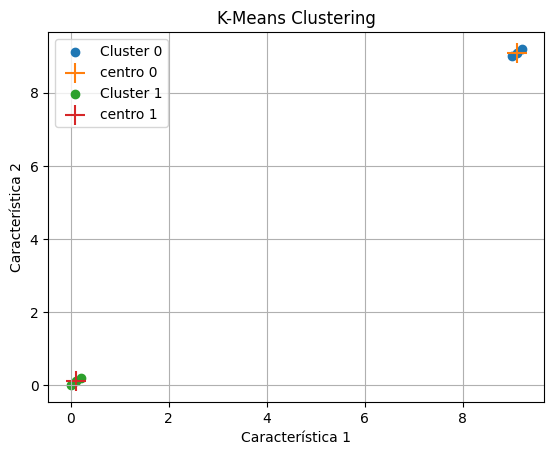

In [95]:
centros = model3.clusterCenters()

for i, centro in enumerate(centros):
    cluster_data = data_array[resultados_cluster == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {i}")
    plt.scatter(centro[0], centro[1], marker="+", s = 200,
                label = f"centro {i}")

plt.title("K-Means Clustering")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.legend()
plt.grid()
plt.show()

> A través esta actividad, pude obtener nuevos conocimientos para el el manejo de grandes volúmenes de datos con Spark. Esto me ayudará a fortalecer mis conocimientos anteriores y saber cómo abordar próximos desafíos que tenga en el área de análisis de datos e inteligencia artificial.